In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy 
from sklearn.model_selection import ParameterGrid
from sklearn.manifold import Isomap
import time
from tqdm import tqdm

import librosa
from librosa import cqt
from librosa.core import amplitude_to_db
from librosa.display import specshow

import os
import glob

In [5]:
data_dir = '/Users/sripathisridhar/Desktop/SOL'

In [6]:
file_paths= sorted(glob.glob(os.path.join(data_dir, '**', '*.wav')))

file_names= []
for file_path in file_paths:
    file_names.append(os.path.basename(file_path))

In [7]:
hop_size= 512
q= 24

In [8]:
import h5py 

with h5py.File("TinySOL.h5", "r") as f:
    features_dict = {key:f[key][()] for key in f.keys()}

In [9]:
grid = {
    'Q': [24],
    'k': [3],
    'comp': ['log'],
    'instr': ['Hp-ord'],
    'dyn': ['all']
}

settings = list(ParameterGrid(grid))

for setting in settings:
    
    if setting["instr"] == 'all':
        setting['instr'] = ''
    
    if setting['dyn'] == 'all':
        setting['dyn'] = ''

In [10]:
batch_str = []
CQT_OCTAVES = 7

features_keys = list(features_dict.keys())

for setting in settings:
    
    q = setting['Q']
    # Batch process and store in a folder
    batch_str = [setting['instr'], setting['dyn']]

    batch_features = []
    for feature_key in features_keys:
        # Get features that match setting
        
        if all(x in feature_key for x in batch_str):
            batch_features.append(features_dict[feature_key])
    
    batch_features = np.stack(batch_features, axis=1)
    
    # Isomap parameters
    hop_size = 512
    compression = 'log'
    features = amplitude_to_db(batch_features)
    n_neighbors = setting['k']
    n_dimensions = 3
    n_octaves = 3    

    # Prune feature matrix
    bin_low = np.where((np.std(features, axis=1) / np.std(features)) > 0.1)[0][0] + q
    bin_high = bin_low + n_octaves*q 
    X = features[bin_low:bin_high, :]

    # Z-score Standardization- improves contrast in correlation matrix
    mus = np.mean(X, axis=1)
    sigmas = np.std(X, axis=1)
    X_std = (X - mus[:, np.newaxis]) / (1e-6 + sigmas[:, np.newaxis]) # 1e-6 to avoid runtime division by zero

    # Pearson correlation matrix
    rho_std = np.dot(X_std, X_std.T) / X_std.shape[1]
    
    # Isomap embedding
    isomap = Isomap(n_components= n_dimensions, n_neighbors= n_neighbors)
    coords = isomap.fit_transform(rho_std)
    
    # Get note value
    freqs= librosa.cqt_frequencies(q*CQT_OCTAVES, fmin=librosa.note_to_hz('C1'), bins_per_octave=q) #librosa CQT default fmin is C1
    chroma_list= librosa.core.hz_to_note(freqs[bin_low:bin_high])
    
    notes = []
    reps = q//12
    for chroma in chroma_list:
        for i in range(reps):
            notes.append(chroma)

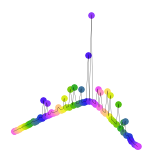

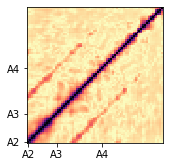

In [11]:
curr_fig= plt.figure(figsize=(5.5, 2.75))
ax= curr_fig.add_subplot(121)
ax.axis('off')

import colorcet as cc
subsampled_color_ids = np.floor(np.linspace(0, 256, q, endpoint=False)).astype('int')
color_list= [cc.cyclic_mygbm_30_95_c78[i] for i in subsampled_color_ids]

# Plot embedding with color
for i in range(coords.shape[0]):
    plt.scatter(coords[i, 0], coords[i, 1], color= color_list[i%q], s=30.0)

plt.plot(coords[:, 0], coords[:, 1], color='black', linewidth=0.2)

# Plot Pearson correlation matrix
rho_frequencies = freqs[bin_low:bin_high]

freq_ticklabels = ['A2', 'A3', 'A4']
freq_ticks = librosa.core.note_to_hz(freq_ticklabels)

tick_bins = []
tick_labels= []
for i,freq_tick in enumerate(freq_ticks):
    tick_bin = np.argmin(np.abs(rho_frequencies-freq_tick))
    tick_bins.append(tick_bin)
    tick_labels.append(freq_ticklabels[i])

plt.figure(figsize=(2.5,2.5))
plt.imshow(np.abs(rho_std), cmap='magma_r')
plt.xticks(tick_bins)
plt.gca().set_xticklabels(freq_ticklabels)
# plt.xlabel('Log-frequency (octaves)')
plt.yticks(tick_bins)
plt.gca().set_yticklabels(freq_ticklabels)
# plt.ylabel('Log-frequency (octaves)')
plt.gca().invert_yaxis()

plt.clim(0, 1)


### Circle projection

In [12]:
import circle_fit
import importlib
importlib.reload(circle_fit)
from circle_fit import circle_fit

A = np.transpose(coords[:,:-1])
x, r, circle_residual = circle_fit(A, verbose=True)

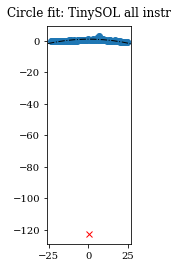

0.11785113019777281


In [13]:
import matplotlib
matplotlib.rc('font', family='serif')

fig, axes = plt.subplots()
plt.scatter(A[0,:],A[1,:])
plt.plot(x[0],x[1],'rx')

circle = plt.Circle(x, radius=r, fill=False, linestyle='-.')

axes.set_aspect(1)
axes.add_artist(circle)

# axes.set_ylim([-5,6])
# axes.set_xlim([-2,8])

plt.title('Circle fit: TinySOL all instr', pad=10.0)
plt.show()

print(np.sqrt(circle_residual)/72)

In [14]:
r

123.68845666079883

In [15]:
def d_squared(a, b):
    # Takes two n-D tuples and returns euclidean distance between them
    
    # Cast to array for computation 
    # Cast first to tuple in case a or b are Sympy Point objects
    p_a = np.array(tuple(a), dtype='float')
    p_b = np.array(tuple(b), dtype='float')
    
    return np.sum(np.square(p_a - p_b))

In [16]:
import sympy

from sympy.geometry import Circle, Point, Line

center = Point(x, evaluate=False)
c = Circle(center, r, evaluate=False)

l = Line(Point(coords[0,:-1]), center, evaluate=False)
points = [tuple(p) for p in l.points]

xy_prime = []

# TODO: Optimize to a more pythonic manner
for x,y in coords[:,:2]:
    
    intersections = c.intersection(Line(Point(x,y), center, evaluate=False))
    
    if d_squared((x,y),intersections[0]) < d_squared((x,y), intersections[1]):
        xy_prime.append([float(p) for p in intersections[0]])
    else:
        xy_prime.append([float(p) for p in intersections[1]])
        

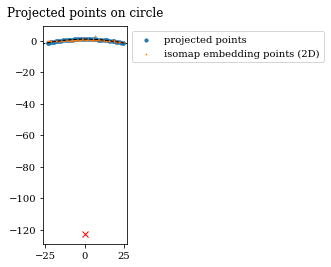

In [17]:
fig, axes = plt.subplots()
plt.scatter(np.array(xy_prime)[:,0],np.array(xy_prime)[:,1], s=10, 
            label='projected points')
plt.scatter(A[0,:],A[1,:], s=0.5, label='isomap embedding points (2D)')
plt.plot(center[0],center[1],'rx')

circle = plt.Circle([float(p) for p in center], radius=r, fill=False, 
                    linestyle='--', label='estimated circle fit')

axes.set_aspect(1)
axes.add_artist(circle)

plt.title('Projected points on circle', pad=10.0)
plt.legend(bbox_to_anchor=(1,1))
plt.show()



### Line projection

In [18]:
z = np.arange(len(coords[:,2]))
z_fit = scipy.stats.linregress(z, coords[:,2])
print(z_fit.stderr)

0.0018336634903286483


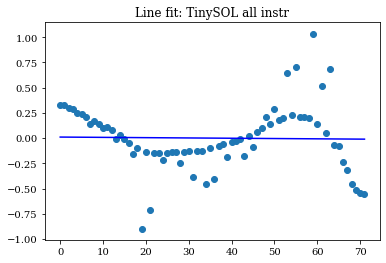

In [19]:
plt.figure()
plt.title('Line fit: TinySOL all instr')
plt.scatter(np.arange(len(coords[:,2])), coords[:,2])

plt.plot(z_fit.intercept + z_fit.slope*z, 'b')

In [20]:
# New line coordinates
z_prime = [i * z_fit.slope + z_fit.intercept for i,_ in enumerate(coords[:,2])]

In [21]:
coords_prime = np.append(np.array(xy_prime), np.expand_dims(np.array(z_prime), axis=1), axis=1)
coords_length = coords_prime.shape[0]

### Distance matrices 

In [22]:
# Projected helix self-distance matrix

D_proj = np.zeros((coords_length, coords_length))
for i in range(coords_length):
    for j in range(i,coords_length):
        
        D_proj[i][j] = d_squared(coords_prime[i,:], coords_prime[j,:])

In [23]:
# Isomap embedding self-distance matrix

D_isomap = np.zeros((coords_length, coords_length)) # Projected points same no. as isomap
for i in range(coords_length):
    for j in range(i, coords_length):
        
        D_isomap[i][j] = d_squared(coords[i,:], coords[j,:])

In [24]:
# Geodesic self-distance matrix

D_geodesic = isomap.dist_matrix_

# Convert to upper triangular sparse matrix
for i in range(coords_length):
    for j in range(i):
        D_geodesic[i,j] = 0

In [25]:
## Centering matrix

def centered(A, Q=24, J=3):
    # Returns centered distance matrix
    
    '''
    Inputs
    -----
    A - squared distance matrix
    Q - quality factor, 24 by default
    J - number of octaves, 3 by default
    
    Returns
    -----
    tau - MDS style diagonalized matrix of A
    '''
    
    coords_length = A.shape[0]
    H = np.zeros((coords_length, coords_length))

    const = 1/(Q*J)
    for i in range(coords_length):
        for j in range(coords_length):
            if j==i:
                H[i,j] = 1 - const
            else:
                H[i,j] = -const
                
    return -0.5 * np.matmul(np.matmul(H, A), H)

In [26]:
def frobenius_distance(A, B):
    # Given two nxn matrices, return their 'Frobenius distance'
    
    return np.sqrt(np.sum(np.square(A - B)))

In [27]:
loss_isomap = frobenius_distance(centered(D_geodesic), centered(D_isomap))/coords_length
loss_total = frobenius_distance(centered(D_geodesic), centered(D_proj))/coords_length
loss_proj = frobenius_distance(centered(D_isomap), centered(D_proj))/coords_length

In [28]:
print(f"Isomap loss= {loss_isomap}")
print(f"Projection loss= {loss_proj}")
print(f"Total loss= {loss_total}")

Isomap loss= 117.47799081825059
Projection loss= 1.0433842670152964
Total loss= 116.82039800129996


In [29]:
(loss_total) - (loss_isomap + loss_proj) < 0

True

In [82]:
## NOT STABLE- REWRITE

helicality_dict[setting['instr']] = [loss_isomap, loss_proj, loss_total]

In [83]:

helicality_dict

{'TpC-ord': [14.780170171262531, 6.90431053444174, 13.687580004785238],
 'Hp-ord': [117.47799081825059, 1.0433842670152964, 116.82039800129996],
 'Fl-ord': [10.860110079953524, 7.292949241337281, 9.508129580612602]}

In [86]:
import json

with open("SOL_instr.json", "w") as outfile:
    json.dump(helicality_dict, outfile)

In [88]:
infile = open("SOL_instr.json")
helicality_data = json.load(infile)
print(helicality_data)

{'TpC-ord': [14.780170171262531, 6.90431053444174, 13.687580004785238], 'Hp-ord': [117.47799081825059, 1.0433842670152964, 116.82039800129996], 'Fl-ord': [10.860110079953524, 7.292949241337281, 9.508129580612602]}
